<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Задание" data-toc-modified-id="Задание-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Задание</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Define-vectorizer-and-model" data-toc-modified-id="Define-vectorizer-and-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define vectorizer and model</a></span></li><li><span><a href="#Get-prediction-for-new-text" data-toc-modified-id="Get-prediction-for-new-text-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Get prediction for new text</a></span></li><li><span><a href="#Попробуем-vowpal-wabbit" data-toc-modified-id="Попробуем-vowpal-wabbit-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Попробуем vowpal wabbit</a></span></li><li><span><a href="#Learn-with-vowpal-wabbit" data-toc-modified-id="Learn-with-vowpal-wabbit-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Learn with vowpal wabbit</a></span></li></ul></div>

## Задание
Необходимо по тексту определить: лучше публиковать его в блоге на Хабрахабр или на Geektimes, другими словами нужно научить алгоритм отличать статьи одного блога от другого. Подразумевается, что текст технический и релевантен тематике данных блогов.

В качестве исходных данных используются два json файла с 1000 текстами с каждого из этих двух сайтов.

In [1]:
import os
import json
import re
from os.path import join
import pandas as pd
import numpy as np

from string import punctuation
from nltk.stem.snowball import RussianStemmer, SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/anton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/anton/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:

RND_SEED = 0
PATH_TO_DATA = "data/habr/"

specSymb = {"«", "»", "—", "“", "-", "№"}
specSymb = punctuation + "«»—“-№"
pattern = re.compile("[" + re.escape(specSymb) + "]")

stopRus = stopwords.words('russian')
stemmer_rus = SnowballStemmer("russian")
stemmer_eng = SnowballStemmer("english")

## Load data

In [3]:
with open(join(PATH_TO_DATA, "geektimes.json")) as f_in:
    jsonka_geek = json.loads(f_in.read())

df_geek = pd.DataFrame.from_dict(jsonka_geek)
df_geek["label"] = pd.Series([0]*len(df_geek))
print("Size of geektimes sample: ", df_geek.shape[0])


with open(join(PATH_TO_DATA, "habrahabr.json")) as f_in:
    jsonka_habr = json.loads(f_in.read())

df_habr = pd.DataFrame.from_dict(jsonka_habr)
df_habr["label"] = pd.Series([1]*len(df_habr))
print("Size of habrahabr sample: ", df_habr.shape[0])


Size of geektimes sample:  997
Size of habrahabr sample:  997


In [4]:
df_all = pd.concat([df_habr, df_geek])
df_all = df_all.reset_index()[["title", "text", "label"]]

In [5]:
def preprocess(text):
    text = text.lower()
    text = re.sub(pattern, '', text)
    text = text.replace('ё', 'е')

    tokens = word_tokenize(text)
    tokens_without_nums = filter(lambda x: not x.isdigit(), tokens)  # skip all numbers
    tokens_without_stop = filter(lambda x: x not in stopRus, tokens_without_nums)
    tokens_stem_rus = map(lambda x: stemmer_rus.stem(x), tokens_without_stop)
    tokens_stem_eng = map(lambda x: stemmer_eng.stem(x), tokens_stem_rus)
    
    return " ".join(tokens_stem_eng)

In [6]:
%%time
df_all["title"] = df_all["title"].apply(preprocess)
df_all["text"] = df_all["text"].apply(preprocess)

CPU times: user 1min 34s, sys: 64 ms, total: 1min 34s
Wall time: 1min 34s


In [7]:
X = df_all["title"].str.cat(pd.Series([' ']*len(df_all))).str.cat(df_all["text"])
y = df_all["label"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = RND_SEED)

In [9]:
X_train.shape[0], X_test.shape[0]

(1595, 399)

## Define vectorizer and model

In [10]:
vect = CountVectorizer(binary=True)
# попробуйте разные типы векторизаторов бинарный, CountVectorizer, TfIdfVectorizer, HashingVectorizer

In [11]:
logreg = LogisticRegression(C=1, solver="liblinear")  # посмотрите, как влияет коэффициент и тип регуляризации

In [12]:
def plot_roc_auc(y_score, y_test):
    fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
    roc_auc = metrics.auc(fpr, tpr)
    f1 = plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc, linewidth=3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    plt.close()

In [13]:
def fit_model(X_train, X_test, y_train, y_test, model, vectorizer):
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)

    print("precision: %s;\nrecall %s" % (precision, recall))
    
    y_score = model.decision_function(X_test)
    plot_roc_auc(y_score, y_test)

precision: 0.8869565217391304;
recall 0.9444444444444444


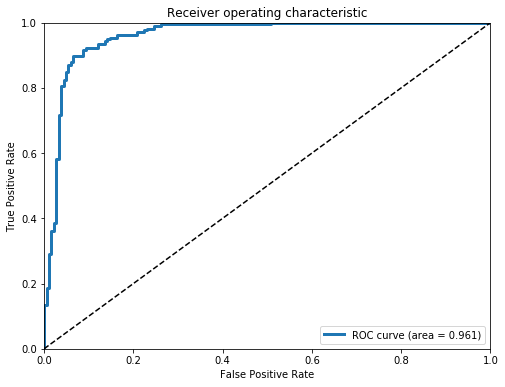

CPU times: user 2.34 s, sys: 120 ms, total: 2.46 s
Wall time: 1.52 s


In [14]:
%%time
fit_model(X_train, X_test, y_train, y_test, logreg, vect)

## Get prediction for new text

In [15]:
def getPrediction(inputTextFile, vectorizer, model):
    """Perform prediction for inputTextFile: on what site this text shoulb be published - GeekTimes or Habrahabr."""
    readFile = open(inputTextFile, encoding='utf8').read()
    t = " ".join(readFile.split())
    proc = preprocess(t)
    vectorize = vectorizer.transform([proc])
    flag = (model.predict_proba(vectorize)[0] == max(model.predict_proba(vectorize)[0]))[0]
    blog = flag and u"GeekTimes" or u"Habrahabr"
    print ("C вероятностью {0} % данный текст опубликован на".format(round(max(model.predict_proba(vectorize)[0])*100,2)), blog)

In [16]:
getPrediction("data/habr/input.txt", vect, logreg)

C вероятностью 99.59 % данный текст опубликован на GeekTimes


##  Попробуем vowpal wabbit

Prepare sample for vw

In [17]:
with open(join(PATH_TO_DATA, "geek_habr_sample_train.vw"), "w") as f_out:
    for idx in X_train.index:
        row = df_all.loc[idx]
        label = row.label
        title = row.title
        text = row.text
        
        if label == 0:
            label = -1 ## AS VW EXSPECTS
            
        line = str(label) + " |title " + title + " |text " + text + "\n"
        f_out.write(line)
        
        
with open(join(PATH_TO_DATA, "geek_habr_sample_test.vw"), "w") as f_out:
    for idx in X_test.index:
        row = df_all.loc[idx]
        label = row.label
        title = row.title
        text = row.text
        
        if label == 0:
            label = -1 ## AS VW EXSPECTS
            
        line = str(label) + " |title " + title + " |text " + text + "\n"
        f_out.write(line)


## Learn with vowpal wabbit

In [18]:
!vw -d data/habr/geek_habr_sample_train.vw --loss_function logistic -f data/habr/vw_trained.model \
                    --ngram 2

/bin/sh: 1: vw: not found


In [19]:
!vw -i data/habr/vw_trained.model -t -d data/habr/geek_habr_sample_test.vw \
                                        -p data/habr/vw_predictions.txt

/bin/sh: 1: vw: not found


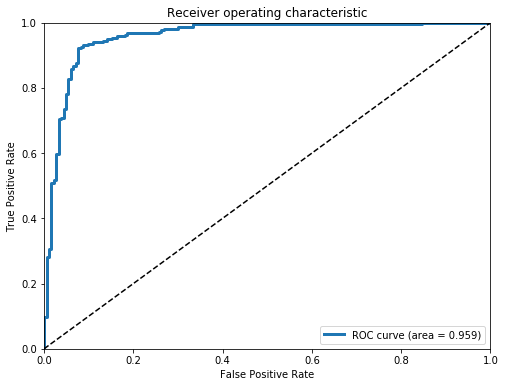

In [20]:
with open('data/habr/vw_predictions.txt') as pred_file:
    y_score_vw = [float(label)
                             for label in pred_file.readlines()]


plot_roc_auc(y_score_vw, y_test)

In [23]:
print(y_score_vw)

[-0.530078, -2.403466, 3.650341, 0.493472, -2.167559, 13.582584, -0.259699, -0.876081, -0.794876, 0.89418, -6.405308, 0.972671, -0.432912, -1.154116, -3.146378, -3.811252, -3.923385, 4.325413, 8.612294, 1.319144, -0.557243, -2.705926, 0.477145, -0.041146, -1.043856, 5.553786, 2.993624, 2.707421, -5.433709, 4.090667, -4.911173, 7.812099, -3.376028, -1.329962, 4.335401, 0.609404, -1.209245, 1.346919, 1.756386, 6.828678, 3.436825, 1.053563, -1.698319, 2.839389, 6.029217, 1.621563, 1.12621, -1.905667, -0.64049, -1.200917, 12.765292, 6.857513, 8.258015, -1.679307, 4.667693, -0.496777, -0.544653, 2.185373, -4.789428, -0.406584, 3.332176, 5.8582, 2.938792, 6.79509, 4.522306, 2.250985, -1.817322, -3.043866, -4.894214, -0.196965, -0.960833, 2.46084, 1.7435, -3.269251, 6.829831, -2.200801, -1.494137, -2.801324, -0.366806, 0.350582, -0.562936, 0.747498, -0.100024, 1.604312, 2.416388, 0.917253, -1.757325, 6.406567, 1.824392, 2.99793, 3.268342, -1.002252, 0.440917, 3.947369, -2.043946, 4.942046, -1

In [21]:
precision = metrics.precision_score(y_test, y_score_vw)
recall = metrics.recall_score(y_test, y_score_vw)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:
y_score_vw[:5]

In [ ]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

y_score_vw_normalized = sigmoid(np.array(y_score_vw))
y_score_vw_normalized = y_score_vw_normalized > 0.55

In [ ]:
precision = metrics.precision_score(y_test, y_score_vw_normalized)
recall = metrics.recall_score(y_test, y_score_vw_normalized)
print("precision: %s;\nrecall %s" % (precision, recall))